<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/8f_BiLSTM_NER_TorchText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de Entidades Nombradas usando una Bi-LSTM

Para resolver esta tarea se usa el conjunto de datos CoNLL-2002 en español

## Conjunto de Datos

In [ ]:
# usar el conjunto de datos de la biblioteca NLTK
import nltk

# descargar el dataset conll2002
nltk.download('conll2002')

nltk.corpus.conll2002.fileids()

[nltk_data] Downloading package conll2002 to /root/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

### Conjuntos de entrenamiento y validación

In [ ]:
# visualizar el conjunto de prueba a
print (' '.join([triple[0] for triple in list(nltk.corpus.conll2002.iob_sents('esp.testa'))[0]]))
print (' '.join([triple[2] for triple in list(nltk.corpus.conll2002.iob_sents('esp.testa'))[0]]))

print ("\n")

for i, x in enumerate(list(nltk.corpus.conll2002.iob_sents('esp.testa'))):
  if i==3: break
  print (x)

Sao Paulo ( Brasil ) , 23 may ( EFECOM ) .
B-LOC I-LOC O B-LOC O O O O O B-ORG O O


[('Sao', 'NC', 'B-LOC'), ('Paulo', 'VMI', 'I-LOC'), ('(', 'Fpa', 'O'), ('Brasil', 'NC', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('23', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFECOM', 'NP', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]
[('-', 'Fg', 'O')]
[('La', 'DA', 'O'), ('multinacional', 'NC', 'O'), ('española', 'AQ', 'O'), ('Telefónica', 'AQ', 'B-ORG'), ('ha', 'VAI', 'O'), ('impuesto', 'VMP', 'O'), ('un', 'DI', 'O'), ('récord', 'NC', 'O'), ('mundial', 'AQ', 'O'), ('al', 'SP', 'O'), ('poner', 'VMN', 'O'), ('en', 'SP', 'O'), ('servicio', 'NC', 'O'), ('tres', 'DN', 'O'), ('millones', 'NC', 'O'), ('de', 'SP', 'O'), ('nuevas', 'AQ', 'O'), ('líneas', 'NC', 'O'), ('en', 'SP', 'O'), ('el', 'DA', 'O'), ('estado', 'NC', 'O'), ('brasileño', 'AQ', 'O'), ('de', 'SP', 'O'), ('Sao', 'NC', 'B-LOC'), ('Paulo', 'VMI', 'I-LOC'), ('desde', 'SP', 'O'), ('que', 'PR', 'O'), ('asumió', 'VMI', 'O'), ('

## Preparar datos

In [ ]:
def saveData(path, data, mode='a'):
    g = open(path, mode)
    g.write(data)
    g.close()

def getData(dataset_name, file_name):
    for sentence in list(nltk.corpus.conll2002.iob_sents(dataset_name)):
        for triple in sentence:
            data = f"{triple[0]}\t{triple[2]}\n"
            saveData(file_name, data)
        saveData(file_name, '\n') # separar oración del resto
    print (f"Se guardo el archivo: {file_name}")



file_name = 'train.tsv'
saveData(file_name, '', mode='w') # resetear/crear archivo
getData('esp.train', file_name)

file_name = 'testa.tsv'
saveData(file_name, '', mode='w') # resetear/crear archivo
getData('esp.testa', file_name)

file_name = 'testb.tsv'
saveData(file_name, '', mode='w') # resetear/crear archivo
getData('esp.testb', file_name)

! ls -lh

Se guardo el archivo: train.tsv
Se guardo el archivo: testa.tsv
Se guardo el archivo: testb.tsv
total 38M
-rw-r--r-- 1 root root 146K Mar 16 21:42 bilstm_loss_accuracy.png
-rw-r--r-- 1 root root  35M Mar 16 22:07 biLSTM-NER-model.pt
drwxr-xr-x 1 root root 4.0K Mar  9 14:48 sample_data
-rw-r--r-- 1 root root 421K Mar 16 22:11 testa.tsv
-rw-r--r-- 1 root root 407K Mar 16 22:11 testb.tsv
-rw-r--r-- 1 root root 2.1M Mar 16 22:11 train.tsv


In [ ]:
# verificar archivos creados
! head -20 testa.tsv

Sao	B-LOC
Paulo	I-LOC
(	O
Brasil	B-LOC
)	O
,	O
23	O
may	O
(	O
EFECOM	B-ORG
)	O
.	O

-	O

La	O
multinacional	O
española	O
Telefónica	B-ORG
ha	O


## Usar TorchText para generar iteradores

In [ ]:
from torchtext.legacy.data import Field, BucketIterator
from torchtext.legacy.datasets import SequenceTaggingDataset

class Corpus(object):
  """Clase que crea los conjutos de datos: entrenamiento, validación y pruebas"""

  def __init__(self, input_folder, min_word_freq, batch_size):
    # crear objetos Field
    self.word_field = Field(lower = True)
    self.tag_field = Field(unk_token = None)

    # crear un conjunto de datos usando un analizador incorporado de torchtext
    self.train_dataset, self.val_dataset, self.test_dataset = SequenceTaggingDataset.splits(
        path = input_folder,
        train = "train.tsv",
        validation = "testa.tsv",
        test = "testb.tsv",
        fields = (("word", self.word_field), ("tag", self.tag_field))
    )

    # convertir campos a lista de vocabulario
    self.word_field.build_vocab(self.train_dataset.word, min_freq = min_word_freq)
    self.tag_field.build_vocab(self.train_dataset.tag)

    # crear iterador para los mini-batch de entrada
    self.train_iter, self.val_iter, self.test_iter = BucketIterator.splits(
        datasets = (self.train_dataset, self.val_dataset, self.test_dataset),
        batch_size = batch_size
    )

    # preparar los índices de relleno para ser ignorado durante el entrenamiento/evaluación del modelo
    self.word_pad_idx = self.word_field.vocab.stoi[self.word_field.pad_token]
    self.tag_pad_idx = self.tag_field.vocab.stoi[self.tag_field.pad_token]

In [ ]:
corpus = Corpus(
    input_folder = ".",
    min_word_freq = 1,  # cualquier palabra que aparezca menos de "n" veces será ignorada del vocabulario
    batch_size = 64
)
print(f"Train set:\t{len(corpus.train_dataset):,} sentences")
print(f"Val set:\t{len(corpus.val_dataset):,} sentences")
print(f"Test set:\t{len(corpus.test_dataset):,} sentences")

print (f"\n{corpus.train_iter.batch_size} es el tamaño de cada batch")
print (f"{len(corpus.train_iter)} batches en el train")
print (f"{len(corpus.val_iter)} batches en el validation")
print (f"{len(corpus.test_iter)} batches en el validation")

Train set:	8,323 sentences
Val set:	1,915 sentences
Test set:	1,517 sentences

64 es el tamaño de cada batch
131 batches en el train
30 batches en el validation
24 batches en el validation


## Definir el modelo de la red Bi-LSTM

In [ ]:
import torch

class BiLSTM(torch.nn.Module):
    """Clase para el modelo Bidirectional Long Short-Term Memory"""

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, lstm_layers, emb_dropout, lstm_dropout, fc_dropout, word_pad_idx):
        super().__init__()

        self.embedding_dim = embedding_dim,

        # capa 1: Embbeddings
        self.embedding = torch.nn.Embedding(
            num_embeddings = input_dim,
            embedding_dim = embedding_dim,
            padding_idx = word_pad_idx
        )

        self.emb_dropout = torch.nn.Dropout(emb_dropout)

        # capa 2. BiLSTM
        self.lstm = torch.nn.LSTM(
            input_size = embedding_dim,
            hidden_size = hidden_dim,
            num_layers = lstm_layers,
            bidirectional = True, # Bi-LSTM
            dropout = lstm_dropout if lstm_layers > 1 else 0
        )

        # capa3. FC
        self.fc_dropout = torch.nn.Dropout(fc_dropout)
        self.fc = torch.nn.Linear(
            in_features = hidden_dim * 2,
            out_features = output_dim
        )

    def forward(self, sentence):
        # sentence = [sentence length, batch size]
        # embedding_out = [sentence length, batch size, embedding dim]
        embedding_out = self.emb_dropout(
            self.embedding(sentence)
        )
        # lstm_out = [sentence length, batch size, hidden dim * 2]
        lstm_out, _ = self.lstm(embedding_out)
        # ner_out = [sentence length, batch size, output dim]
        ner_out = self.fc(
            self.fc_dropout(lstm_out)
        )

        return ner_out
    
    def init_weights(self):
        # inicializar todos los parámetros de una distribución normal
        # ayuda a converger durante el entrenamiento
        for name, param in self.named_parameters():
            torch.nn.init.normal_(param.data, mean=0, std=0.1)
    
    def init_embeddings(self, word_pad_idx):
        # inicializar el embeddings para el relleno (pad) como cero
        self.embedding.weight.data[word_pad_idx] = torch.zeros(self.embedding_dim)
    
    def count_parameters(self):
        return sum( p.numel() for p in self.parameters() if p.requires_grad )

### Definir funciones para el entrenamiento

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def accuracy(preds, y):
    # print (f" y shape --> {y.shape}")
    # print (f" y --> {y}")
    # print (f"preds shape --> {preds.shape}")
    # print (f"preds --> {preds}")
    max_preds = preds.argmax(dim=1, keepdim=True)  # get the index of the max probability
    # print (f"max_preds --> {max_preds.shape}")
    # print (f"corpus.tag_pad_idx --> {corpus.tag_pad_idx}")
    # print (f"y != corpus.tag_pad_idx --> {y != corpus.tag_pad_idx}")
    # exit(0)
    non_pad_elements = (y != corpus.tag_pad_idx).nonzero()  # obtener vector de etiquetas sin el relleno
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]])

def index2word(data):
    """método para convertir los índices a sus etiquetas"""
    return [corpus.tag_field.vocab.itos[index] for index in data]

In [ ]:
def train(model, iterator, optimizer, loss_function):
    """
    Entrenar el modelo, recibe el conjunto de datos (iterator), optimizador, y la función de pérdida
    Retorna el loss y el accuracy
    """
    from tqdm.auto import tqdm

    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    # for batch in tqdm(iterator, desc="Entrenamiento", total=len(iterator)):
    for batch in iterator:
        text = batch.word
        true_tags = batch.tag

        # restablecer el gradiente
        optimizer.zero_grad()

        # obtener las predicciones del batch en proceso
        pred_tags = model(text)

        # to calculate the loss and accuracy, we flatten both prediction and true tags
        # flatten pred_tags to [sent len, batch size, output dim]
        # -----------------------------------------------------
        # print (f"pred_tags:\t{pred_tags.size()}")
        # -----------------------------------------------------
        pred_tags = pred_tags.view(-1, pred_tags.shape[-1])
        # -----------------------------------------------------
        # print (f"pred_tags flatten:\t{pred_tags.size()}")
        # print (f"true_tags:\t{true_tags.size()}")
        # -----------------------------------------------------
        # flatten true_tags to [sent len * batch size]
        true_tags = true_tags.view(-1)
        # -----------------------------------------------------
        # print (f"true_tags:\t{true_tags.size()}")
        # -----------------------------------------------------
        # obtener la pérdida 
        batch_loss = loss_function(pred_tags, true_tags)
        
        # calcular el accuracy
        batch_acc = accuracy(pred_tags, true_tags)

        # `clip_grad_norm` ayuda a prevenir el problema del gradiente explosivo en RNN / LSTM
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        # backpropagation
        batch_loss.backward()
        
        # Actualizar (optimizar) los pesos
        optimizer.step()
        
        epoch_loss += batch_loss.item()
        epoch_acc += batch_acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, loss_function):
    """
    Evaluar el conjunto de validación
    Retorna el loss y accuracy
    """
    from tqdm.auto import tqdm
    epoch_loss = 0
    epoch_acc = 0
    
    word_prediction, tag_prediction = [], []

    # indicar la evaluación del modelo
    model.eval()
    
    # No utilizar cálculos del gradiente
    with torch.no_grad():
        # for batch in tqdm(iterator, desc="Evaluación", total=len(iterator)):
        for batch in iterator:
            text = batch.word
            true_tags = batch.tag
            
            pred_tags = model(text)
            pred_tags = pred_tags.view(-1, pred_tags.shape[-1])
            true_tags = true_tags.view(-1)
            batch_loss = loss_function(pred_tags, true_tags)
            batch_acc = accuracy(pred_tags, true_tags)
            epoch_loss += batch_loss.item()
            epoch_acc += batch_acc.item()

            # realizar predicciones
            max_preds = pred_tags.argmax(dim=1, keepdim=True)  # get the index of the max probability
            # print (f"max_preds:\t{max_preds}\n{max_preds.shape}")
            non_pad_elements = (true_tags != corpus.tag_pad_idx).nonzero()  # obtener vector de etiquetas sin el relleno
            # print (f"\nnon_pad_elements:\t{non_pad_elements}\n{non_pad_elements.shape}")
            correct = max_preds[non_pad_elements].squeeze(1).eq(true_tags[non_pad_elements])      
            # print (f"\ncorrect:\t{correct}\n{correct.shape}")
            # predecidos = max_preds[non_pad_elements].squeeze(1)
            # verdaderos = true_tags[non_pad_elements]
            # print (f"\npredecidos:\t{predecidos}\n{len(predecidos)}")
            # print (f"verdaderos:\t{verdaderos}\n{len(verdaderos)}")
            # predicted_tags = [corpus.tag_field.vocab.itos[t.item()] for t in max_preds]
            # print (f"\npredicted_tags:\t{predicted_tags}\n{predicted_tags.shape}")
            # almacenar las predicciones
           

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluateTest(model, iterator, loss_function):
    """
    Evaluar el conjunto de prueba
    Retorna el loss y accuracy
    """
    from tqdm.auto import tqdm
    epoch_loss = 0
    epoch_acc = 0
    
    word_prediction, tag_prediction = [], []
    y_true, y_pred = [], []

    # indicar la evaluación del modelo
    model.eval()
    
    # No utilizar cálculos del gradiente
    with torch.no_grad():
        # for batch in tqdm(iterator, desc="Evaluación", total=len(iterator)):
        for batch in iterator:
            text = batch.word
            true_tags = batch.tag
            
            pred_tags = model(text)
            pred_tags = pred_tags.view(-1, pred_tags.shape[-1])
            true_tags = true_tags.view(-1)
            batch_loss = loss_function(pred_tags, true_tags)
            batch_acc = accuracy(pred_tags, true_tags)
            epoch_loss += batch_loss.item()
            epoch_acc += batch_acc.item()

            # realizar predicciones
            max_preds = pred_tags.argmax(dim=1, keepdim=True)  # get the index of the max probability
            # print (f"max_preds:\t{max_preds}\n{max_preds.shape}")
            non_pad_elements = (true_tags != corpus.tag_pad_idx).nonzero()  # obtener vector de etiquetas sin el relleno
            # print (f"\nnon_pad_elements:\t{non_pad_elements}\n{non_pad_elements.shape}")
            correct = max_preds[non_pad_elements].squeeze(1).eq(true_tags[non_pad_elements])      
            # print (f"\ncorrect:\t{correct}\n{correct.shape}")
            predecidos = max_preds[non_pad_elements].squeeze(1).squeeze(1)
            verdaderos = true_tags[non_pad_elements].squeeze(1)
            # print (f"\npredecidos:\t{predecidos}\n{len(predecidos)}")
            # print (f"verdaderos:\t{verdaderos}\n{len(verdaderos)}")

            real_tags = [corpus.tag_field.vocab.itos[t.item()] for t in verdaderos]
            predicted_tags = [corpus.tag_field.vocab.itos[t.item()] if t.item() > 0 else corpus.tag_field.vocab.itos[1] for t in predecidos]
            # print (f"\npredicted_tags:\t{predicted_tags}\n{len(predicted_tags)}")

            # real_tags = [corpus.tag_field.vocab.itos[t.item()] for t in verdaderos]
            # print (f"\nreal_tags:\t{real_tags}\n{len(real_tags)}")
            # almacenar las predicciones
            
            # verdaderos = index2word(verdaderos.tolist())
            # predecidos = index2word(predecidos.tolist())

            y_true.append( real_tags )
            y_pred.append( predicted_tags )


            

            # basura

    return epoch_loss / len(iterator), epoch_acc / len(iterator), y_true, y_pred

## Entrenar el modelo

In [ ]:
# instanciar el modelo
model = BiLSTM(
    input_dim = len(corpus.word_field.vocab),
    embedding_dim = 300, # 300,
    hidden_dim = 128, # 64,
    output_dim = len(corpus.tag_field.vocab), # no contar el token de relleno
    lstm_layers = 2,
    emb_dropout = 0.5,
    lstm_dropout = 0.1,
    fc_dropout = 0.25,
    word_pad_idx = corpus.word_pad_idx
)

# inicializar los pesos
model.init_weights()

# definir el embedding para el relleno (pad)
model.init_embeddings(
    word_pad_idx = corpus.word_pad_idx
)

print (f"El modelo tiene {model.count_parameters():,} parámeros entrenebles\n")

print (model)

El modelo tiene 7,951,754 parámeros entrenebles

BiLSTM(
  (embedding): Embedding(23712, 300, padding_idx=1)
  (emb_dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.1, bidirectional=True)
  (fc_dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
# entrenar el modelo
import time
from tqdm.auto import tqdm

optimizer = torch.optim.Adam(model.parameters())
loss_function = torch.nn.CrossEntropyLoss(ignore_index=corpus.word_pad_idx)

EPOCHS = 10 # 20
# float('inf') actúa como un valor superior ilimitado para la comparación.
# esto es útil para encontrar los valores más bajos para algo
best_valid_loss = float('inf')
val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

print ("Entrenamiento en progreso...\n")

# for epoch in tqdm(range(EPOCHS), desc="BiLSTM", total=EPOCHS):
for epoch in range(EPOCHS):
    # calcular el tiempo que tarda cada epoca
    start_time = time.time()

    # obtener el loss del conjunto de entrenamiento
    train_loss, train_acc = train(model, corpus.train_iter, optimizer, loss_function)

    # obtener el loss del conjunto de validación
    valid_loss, valid_acc = evaluate(model, corpus.val_iter, loss_function)

    end_time = time.time() # obtener el tiempo final
    # obtener los minutos y segundos del tiempo de ejecución
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Almacenar las metricas del entrenamiento
    val_loss.append(valid_loss)
    val_acc.append(valid_acc)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)

    print(f"Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins} minutos {epoch_secs} segundos")
    print(f"\tTrn Loss: {train_loss:.3f} | Trn Acc: {train_acc * 100:.2f}%")
    print(f"\tVal Loss: {valid_loss:.3f} | Val Acc: {valid_acc * 100:.2f}%")
    # test_loss, test_acc = self.evaluate(self.data.test_iter)
    # print(f"Test Loss: {test_loss:.3f} |  Test Acc: {test_acc * 100:.2f}%")

    if valid_loss < best_valid_loss: # guardar el mejor modelo
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'biLSTM-NER-model.pt')

Entrenamiento en progreso...

Epoch: 01 | Epoch Time: 1 minutos 56 segundos
	Trn Loss: 0.263 | Trn Acc: 2.96%
	Val Loss: 1.023 | Val Acc: 6.26%
Epoch: 02 | Epoch Time: 1 minutos 53 segundos
	Trn Loss: 0.106 | Trn Acc: 6.84%
	Val Loss: 0.687 | Val Acc: 8.92%
Epoch: 03 | Epoch Time: 1 minutos 54 segundos
	Trn Loss: 0.057 | Trn Acc: 9.31%
	Val Loss: 0.520 | Val Acc: 10.16%
Epoch: 04 | Epoch Time: 1 minutos 53 segundos
	Trn Loss: 0.036 | Trn Acc: 10.52%
	Val Loss: 0.478 | Val Acc: 10.53%
Epoch: 05 | Epoch Time: 1 minutos 53 segundos
	Trn Loss: 0.025 | Trn Acc: 11.26%
	Val Loss: 0.461 | Val Acc: 10.71%
Epoch: 06 | Epoch Time: 1 minutos 54 segundos
	Trn Loss: 0.019 | Trn Acc: 11.44%
	Val Loss: 0.468 | Val Acc: 10.86%
Epoch: 07 | Epoch Time: 1 minutos 54 segundos
	Trn Loss: 0.014 | Trn Acc: 11.63%
	Val Loss: 0.484 | Val Acc: 10.85%
Epoch: 08 | Epoch Time: 1 minutos 54 segundos
	Trn Loss: 0.011 | Trn Acc: 11.79%
	Val Loss: 0.496 | Val Acc: 10.92%
Epoch: 09 | Epoch Time: 1 minutos 54 segundos
	

## Visualizar gráficas de pérdida y exactitud

In [ ]:
def plotLossAndAccuracy(tr_loss, val_loss, tr_acc, val_acc, name="bilstm_loss_accuracy.png"):
    """Graficar las exactitudes y pérdidas del modelo de entrenamiento y validación"""
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].plot(tr_loss, label='Training loss')
    ax[0].plot(val_loss, label='Validation loss')
    ax[0].set_title('Losses')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot(val_acc, label='Validation accuracy')
    ax[1].plot(tr_acc, label='Training accuracy')
    ax[1].set_title('Accuracies')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    plt.legend()
    plt.savefig(fname=name, dpi=200, format="png")

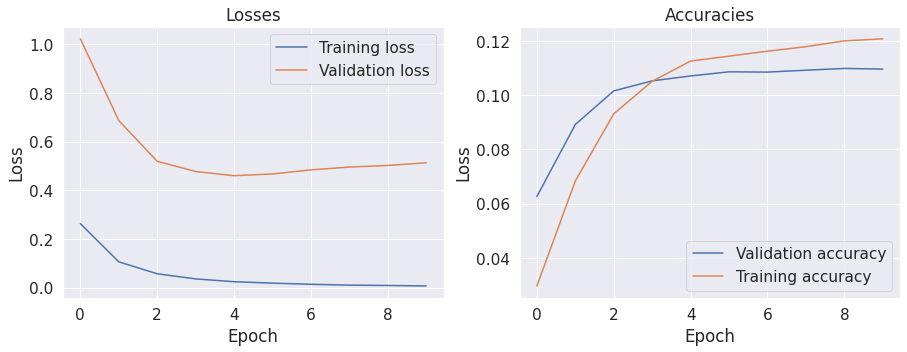

In [ ]:
plotLossAndAccuracy(tr_loss, val_loss, tr_acc, val_acc)

## Evaluar el conjunto de prueba

In [ ]:
# ! pip install -U seqeval
from seqeval.metrics import classification_report as seq_cr
from seqeval.metrics import accuracy_score as seq_acc
from sklearn.metrics import classification_report as skl_cr
from sklearn.metrics import accuracy_score as skl_acc

model.load_state_dict(torch.load('biLSTM-NER-model.pt'))

test_loss, test_acc, y_true, y_pred = evaluateTest(model, corpus.test_iter, loss_function)

labels = list(corpus.tag_field.vocab.stoi.keys())
labels.remove('<pad>')
labels.remove('O')

y_true_tmp = [item for lst in y_true for item in lst]
y_pred_tmp = [item for lst in y_pred for item in lst]

print (f"{skl_acc(y_true_tmp, y_pred_tmp):.2f} accuracy por esquema IOB")
print (f"{seq_acc(y_true, y_pred):.2f} accuracy por clase")
print (f"\n{'-'*60}\n")

print ( skl_cr(y_true_tmp, y_pred_tmp, labels=labels) )
print (f"\n{'-'*60}\n")
print ( seq_cr(y_true, y_pred) )


0.11 accuracy por esquema IOB
0.11 accuracy por clase

------------------------------------------------------------

              precision    recall  f1-score   support

       B-ORG       0.07      0.82      0.13      1400
       I-ORG       0.17      0.81      0.29      1104
       B-LOC       0.08      0.67      0.14      1084
       B-PER       0.15      0.90      0.25       735
       I-PER       0.20      0.94      0.33       634
      I-MISC       0.09      0.70      0.15       557
      B-MISC       0.04      0.66      0.07       339
       I-LOC       0.12      0.66      0.20       325

   micro avg       0.10      0.79      0.17      6178
   macro avg       0.11      0.77      0.20      6178
weighted avg       0.11      0.79      0.20      6178


------------------------------------------------------------

              precision    recall  f1-score   support

         LOC       0.08      0.64      0.15      1392
        MISC       0.05      0.59      0.10       879
      

## Matriz de confusión por esquema IOB

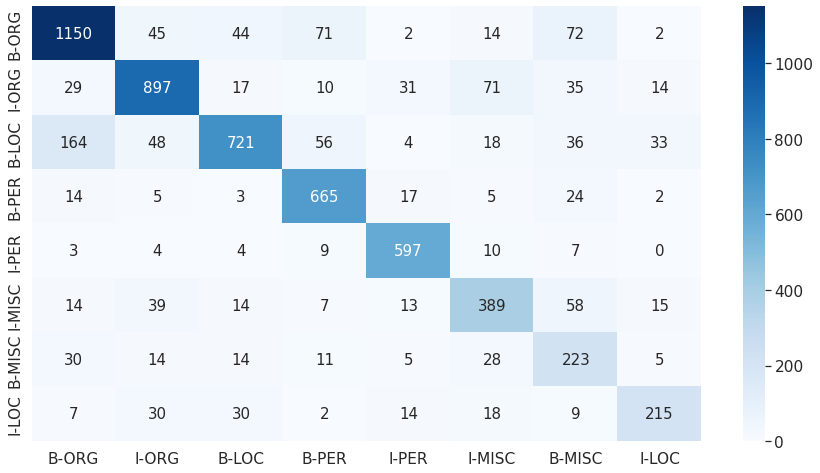

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = list(corpus.tag_field.vocab.stoi.keys())
labels.remove('<pad>')
labels.remove('O')

cm = confusion_matrix(y_true_tmp, y_pred_tmp, labels=labels)

sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='', cmap='Blues', annot_kws={'size': 15}, xticklabels=labels, yticklabels=labels)
plt.show()